**Roujia Zhong & Luhang Sun**

Fall 2020

CS 343: Neural Networks

Project 2: Multi-layer Perceptrons

**Submission reminders:**

- Submit rubric on Google Classroom (one per team)
- Submit one .zip file per team on Google Classroom. Includes:
    - All .ipynb notebook files
    - All .py code files
    - Data files under 10 MB
- Did you answer all 9 questions?

In [19]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# for obtaining the STL-dataset
import load_stl10_dataset

# for preprocessing dataset
import preprocess_data

# Set the color style so that Professor Layton can see your plots
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
# Make the font size larger
plt.rcParams.update({'font.size': 20})

# Turn off scientific notation when printing
np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

def plot_cross_entropy_loss(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Training iteration')
    plt.ylabel('loss (cross-entropy)')
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in data

### a. STL-10

Run your function to load in the preprocessed STL-10 data in the following split:

- 3500 training samples
- 500 test samples
- 500 validation samples
- 500 samples for development

In [17]:
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = preprocess_data.load_stl10()

Found cached numpy arrays the images and labels. Loading them...
Images are: (5000, 32, 32, 3)
Labels are: (5000,)


### b. Circle in a square

The circle in a square (CIS) dataset is a simple binary classification dataset that is useful for debugging and visualizing what your MLP is learning. Points with (x, y) coordinates inside a circle have class value of 1, points with coordinates outside the circle have class value of 0. Training on the CIS dataset allows us to answer the question: can the MLP discriminate whether a test point falls inside or outside the circle?

#### Todo

- Download the CIS dataset then run the cell below to load in the CIS train (`cis_train.dat`) and test (`cis_test.dat`) sets as numpy arrays.
- Below, make a scatterplot showing the test set data. Color-code samples based on their class. If everything goes well, you should see a...solid, filled in circle inside unit square :)
    - Make the aspect ratio of your x, y plotting axes equal, otherwiwse you might see an ellipse!

In case you're curious about the data format:
- Like usual, each row is a different sample.
- The x-coordinate feature is the 1st column
- The y-coordinate feature is the 2nd column
- The class label (0 or 1) is in the third column.


In [22]:
val_size = 20

cis_train_path = os.path.join('data', 'cis', 'cis_train.dat')
cis_test_path = os.path.join('data', 'cis', 'cis_test.dat')

cis_train_all = np.loadtxt(cis_train_path, delimiter='\t')

# shuffle the data
s_inds = np.arange(len(cis_train_all))
np.random.seed(0)
np.random.shuffle(s_inds)

cis_train_all = cis_train_all[s_inds]

cis_train_x = cis_train_all[:, :2]
cis_train_y = cis_train_all[:, 2].astype(int)

cis_val_x = cis_train_x[:val_size]
cis_train_x = cis_train_x[val_size:]
cis_val_y = cis_train_y[:val_size]
cis_train_y = cis_train_y[val_size:]

cis_test_all = np.loadtxt(cis_test_path, delimiter='\t')
cis_test_x = cis_test_all[:, :2]
cis_test_y = cis_test_all[:, 2].astype(int)

print ('CIS Train data shape: ', cis_train_x.shape)
print ('CIS Train labels shape: ', cis_train_y.shape)
print ('CIS Validation data shape: ', cis_val_x.shape)
print ('CIS Validation labels shape: ', cis_val_y.shape)
print ('CIS Test data shape: ', cis_test_x.shape)
print ('CIS Test labels shape: ', cis_test_y.shape)

CIS Train data shape:  (80, 2)
CIS Train labels shape:  (80,)
CIS Validation data shape:  (20, 2)
CIS Validation labels shape:  (20,)
CIS Test data shape:  (10000, 2)
CIS Test labels shape:  (10000,)


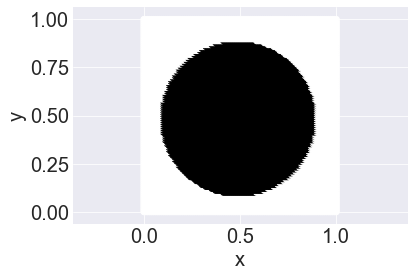

In [23]:
#make a scatterplot
plt.scatter(cis_test_all[:,0], cis_test_all[:,1], c=cis_test_all[:,2])
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

## Task 3: Implement Multilayer Perceptron (MLP) with softmax activation and cross-entropy loss

Now that we've tested the softmax activation function and cross-entropy loss functions in a single-layer net, let's implement the MLP version.

Much of your work on the single layer net will carry over, so go ahead and copy-paste and modify as needed!

The structure of our MLP will be:

```
Input layer (X units) ->
Hidden layer (Y units) with Rectified Linear activation (ReLu) ->
Output layer (Z units) with softmax activation
```

### 3a. Implement the following functions in `mlp.py`

- `initialize_wts`
- `accuracy`
- `one_hot`
- `predict`
- `forward`
- `backward`
- `fit`

### 3b. Test key functions with randomly generated data

In [6]:
from mlp import MLP

In [63]:
# Create a dummy net for debugging
num_inputs = 3
num_features = 6
num_hidden_units = 7
num_classes = 5

net = MLP(num_features, num_hidden_units, num_classes)

In [64]:
# Generate random data and classes
np.random.seed(0)
test_x = np.random.normal(loc=0, scale=100, size=(num_inputs, num_features))
test_y = np.random.uniform(low=0, high=num_classes-1, size=(num_inputs,))
test_y = test_y.astype(int)
print(f'Test input shape: {test_x.shape}')
print(f'Test class vector shape: {test_y.shape}')

Test input shape: (3, 6)
Test class vector shape: (3,)


#### Test `initialize_wts`

In [65]:
net.initialize_wts(M=num_features, H=num_hidden_units, C=num_classes, std=0.01)
print(f'y wt shape is {net.y_wts.shape} and should be (6, 7)')
print(f'y bias shape is {net.y_b.shape} and should be (7,)')
print(f'z wt shape is {net.z_wts.shape} and should be (7, 5)')
print(f'z bias shape is {net.z_b.shape} and should be (5,)')

print(f'1st few y wts are\n{net.y_wts[:,0]}\nand should be\n[ 0.018 -0.002  0.004  0.007  0.015  0.002]')
print(f'y bias is\n{net.y_b}\nand should be\n[-0.017  0.02  -0.005 -0.004 -0.013  0.008 -0.016]')
print(f'1st few z wts are\n{net.z_wts[:,0]}\nand should be\n[-0.002 -0.    -0.004  0.002  0.001  0.004  0.001]')
print(f'z bias is\n{net.z_b}\nand should be\n[ 0.015  0.019  0.012 -0.002 -0.011]')

y wt shape is (6, 7) and should be (6, 7)
y bias shape is (7,) and should be (7,)
z wt shape is (7, 5) and should be (7, 5)
z bias shape is (5,) and should be (5,)
1st few y wts are
[ 0.018 -0.002  0.004  0.007  0.015  0.002]
and should be
[ 0.018 -0.002  0.004  0.007  0.015  0.002]
y bias is
[-0.017  0.02  -0.005 -0.004 -0.013  0.008 -0.016]
and should be
[-0.017  0.02  -0.005 -0.004 -0.013  0.008 -0.016]
1st few z wts are
[-0.002 -0.    -0.004  0.002  0.001  0.004  0.001]
and should be
[-0.002 -0.    -0.004  0.002  0.001  0.004  0.001]
z bias is
[ 0.015  0.019  0.012 -0.002 -0.011]
and should be
[ 0.015  0.019  0.012 -0.002 -0.011]


#### Test the `predict` method

In [66]:
test_y_pred = net.predict(test_x)
print(f'Predicted classes are {test_y_pred} and should be [3 0 0]')

Predicted classes are [3 0 0] and should be [3 0 0]


#### Test the `forward` method focusing on`ReLU`(net act of hidden layer `y`)

In [67]:
_,y_net_act_test,_,_,_ = net.forward(test_x, test_y)

correct_y_act = np.array([[7.643, 4.49 , 0.799, 9.977, 0.   , 0.   , 0.   ],
       [2.353, 2.737, 2.175, 2.547, 0.345, 0.   , 0.   ],
       [3.98 , 2.691, 1.19 , 3.029, 0.   , 0.   , 0.   ]])

print(f'Your y activation is\n{y_net_act_test}')
print(f'The correct y activation (ReLU) is\n{correct_y_act}')

Your y activation is
[[7.643 4.49  0.799 9.977 0.    0.    0.   ]
 [2.353 2.737 2.175 2.547 0.345 0.    0.   ]
 [3.98  2.691 1.19  3.029 0.    0.    0.   ]]
The correct y activation (ReLU) is
[[7.643 4.49  0.799 9.977 0.    0.    0.   ]
 [2.353 2.737 2.175 2.547 0.345 0.    0.   ]
 [3.98  2.691 1.19  3.029 0.    0.    0.   ]]


#### Test the `forward` method

In [68]:
_,_,_,probs,_ = net.forward(test_x, test_y)

correct_probs = np.array([[0.219, 0.2  , 0.191, 0.219, 0.171],
       [0.208, 0.204, 0.201, 0.205, 0.183],
       [0.208, 0.202, 0.202, 0.205, 0.183]])

print(f'Your z activation (class probabilities) is\n{probs}')
print(f'The correct z activation (class probabilities) is\n{correct_probs}')
print(f'The sums across rows (for each data sample) are {np.sum(probs, axis=1)}.')
print(f'  You should know what should be :)')

Your z activation (class probabilities) is
[[0.219 0.2   0.191 0.219 0.171]
 [0.208 0.204 0.201 0.205 0.183]
 [0.208 0.202 0.202 0.205 0.183]]
The correct z activation (class probabilities) is
[[0.219 0.2   0.191 0.219 0.171]
 [0.208 0.204 0.201 0.205 0.183]
 [0.208 0.202 0.202 0.205 0.183]]
The sums across rows (for each data sample) are [1. 1. 1.].
  You should know what should be :)


#### Test the `forward` method, focusing on loss

In [69]:
y_in, y_act ,z_in, z_act, loss = net.forward(test_x, test_y)
correct_loss = 1.564402690536365

print(f'Your average loss is\n{loss}')
print(f'The correct average loss is approx\n{correct_loss}')

Your average loss is
1.5644026905363648
The correct average loss is approx
1.564402690536365


#### Test the `forward` method, focusing on regularization

In [72]:
y_in, y_act ,z_in, z_act, loss = net.forward(test_x, test_y, reg=1000)
correct_loss = 5.257207314928798

print(f'Your regularized average loss is\n{loss}')
print(f'The correct regularized average loss is approx\n{correct_loss}')

Your regularized average loss is
5.257207314928798
The correct regularized average loss is approx
5.257207314928798


#### Test the `backward` method

In [73]:
y_in, y_act ,z_in, z_act, loss = net.forward(test_x, test_y, reg=0.5)
grads = net.backward(test_x, test_y, y_in, y_act ,z_in, z_act, reg=0.5)

print('Your gradient for y_wts is\n', grads[0])
print('Your gradient for y_b is\n', grads[1])
print('Your gradient for z_wts is\n', grads[2])
print('Your gradient for z_b is\n', grads[3])

Your gradient for y_wts is
 [[-0.476  0.057 -0.458 -0.115  0.03  -0.005  0.005]
 [-0.002  0.014 -0.046 -0.162  0.004  0.004  0.001]
 [-0.088  0.038 -0.166 -0.325 -0.001 -0.004 -0.013]
 [-0.331  0.067 -0.398 -0.332  0.001  0.    -0.001]
 [-0.318  0.089 -0.465 -0.615 -0.001 -0.01  -0.002]
 [-0.315 -0.036 -0.036  0.806  0.029 -0.005 -0.007]]
Your gradient for y_b is
 [-0.005  0.    -0.004 -0.     0.     0.     0.   ]
Your gradient for z_wts is
 [[-2.879  0.933  0.131  0.987  0.816]
 [-1.69   0.669 -0.261  0.699  0.584]
 [-0.374  0.278 -0.45   0.284  0.242]
 [-3.221  1.041  0.154  1.111  0.904]
 [ 0.024  0.027 -0.091  0.029  0.015]
 [ 0.002 -0.003 -0.004 -0.003 -0.002]
 [ 0.    -0.006  0.005  0.002 -0.008]]
Your gradient for z_b is
 [-0.455  0.202 -0.135  0.209  0.179]


The correct gradients are:
`
Your gradient for y_wts is
 [[-0.476  0.057 -0.458 -0.115  0.03  -0.005  0.005]
 [-0.002  0.014 -0.046 -0.162  0.004  0.004  0.001]
 [-0.088  0.038 -0.166 -0.325 -0.001 -0.004 -0.013]
 [-0.331  0.067 -0.398 -0.332  0.001  0.    -0.001]
 [-0.318  0.089 -0.465 -0.615 -0.001 -0.01  -0.002]
 [-0.315 -0.036 -0.036  0.806  0.029 -0.005 -0.007]]
Your gradient for y_b is
 [-0.005  0.    -0.004 -0.     0.     0.     0.   ]
Your gradient for z_wts is
 [[-2.879  0.933  0.131  0.987  0.816]
 [-1.69   0.669 -0.261  0.699  0.584]
 [-0.374  0.278 -0.45   0.284  0.242]
 [-3.221  1.041  0.154  1.111  0.904]
 [ 0.024  0.027 -0.091  0.029  0.015]
 [ 0.002 -0.003 -0.004 -0.003 -0.002]
 [ 0.    -0.006  0.005  0.002 -0.008]]
Your gradient for z_b is
 [-0.455  0.202 -0.135  0.209  0.179]
`

#### Test loss over epoch (1 of 2). 

The below code should generate a curve that rapidly drops to 0 (there might be fluctuations and it might not be monotonic and that's ok)

Your `fit` function should show you print-outs showing:
- Loss and validation accuracy 4 times throughout training.
- 100% accuracy on validation set after around 5 epochs of training.
- You are training on 20 epochs.
- There are 20 iterations.
- There is 1 iteration per epoch.

Here is an example print-out from `fit`:

    Starting to train network...There will be 20 epochs and 20 iterations total, 1 iter/epoch.
     Completed Epoch 0/19. Training loss: 3.78. Validation accuracy: 33.33%.
     Completed Epoch 5/19. Training loss: 0.13. Validation accuracy: 100.00%.
     Completed Epoch 10/19. Training loss: 0.22. Validation accuracy: 100.00%.
     Completed Epoch 15/19. Training loss: 0.15. Validation accuracy: 100.00%.
    Finished training!


No.epoch: 0
final lose: 2.0582431769411276
training acc: 0.6666666666666667
val acc: 0.6666666666666667
-----------
No.epoch: 5
final lose: 0.27796067429731686
training acc: 1.0
val acc: 1.0
-----------
No.epoch: 10
final lose: 0.1600468825240505
training acc: 1.0
val acc: 1.0
-----------
No.epoch: 15
final lose: 0.10468899485785539
training acc: 1.0
val acc: 1.0
-----------

Lengths of each output list:
20, 20, 20
Each should be 20.


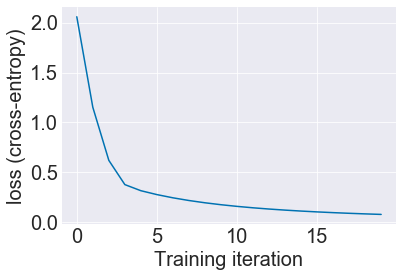

In [74]:
net = MLP(num_features, num_hidden_units, num_classes)
loss_hist, acc_train, acc_valid = net.fit(test_x, test_y, test_x, test_y, reg=0, print_every=5, lr=0.001, mini_batch_sz=3, n_epochs=20)

print('\nLengths of each output list:')
print(f'{len(loss_hist)}, {len(acc_train)}, {len(acc_valid)}')
print('Each should be 20.')

plot_cross_entropy_loss(loss_hist)

#### Test loss over epoch (2 of 2). 

The below curve should be more jagged that above, but still converge to 0 loss.

Your `fit` function should print out:
- Loss and validation accuracy 5 times throughout training.
- 100% accuracy on validation set after around 4 epochs of training.
- You are training on 10 epochs.
- There are 30 iterations.
- There are 3 iterations per epoch.


No.epoch: 0
final lose: 7.566429802896791
training acc: 0.6666666666666667
val acc: 0.6666666666666667
-----------
No.epoch: 2
final lose: 3.8252986288575715e-08
training acc: 0.6666666666666667
val acc: 0.6666666666666667
-----------
No.epoch: 4
final lose: 0.618698224461498
training acc: 1.0
val acc: 1.0
-----------
No.epoch: 6
final lose: 0.06549729481908131
training acc: 1.0
val acc: 1.0
-----------
No.epoch: 8
final lose: 0.0565732843849975
training acc: 1.0
val acc: 1.0
-----------

Lengths of each output list:
30, 10, 10
The lengths should be 30, 10, 10.


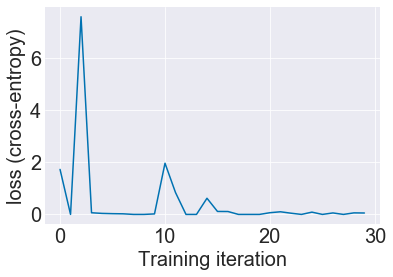

In [76]:
net = MLP(num_features, num_hidden_units, num_classes)
loss_hist, acc_train, acc_valid = net.fit(test_x, test_y, test_x, test_y, reg=0, print_every=2, lr=0.001, mini_batch_sz=1, n_epochs=10)

print('\nLengths of each output list:')
print(f'{len(loss_hist)}, {len(acc_train)}, {len(acc_valid)}')
print('The lengths should be 30, 10, 10.')

plot_cross_entropy_loss(loss_hist)

### 3c. Test MLP with Circle in Square dataset

Before you run your MLP on the STL-10 dataset, test it out on the simpler CIS dataset.

In cells below:
- Train an MLP using the CIS training and validation sets. Configure the MLP with the following non-default hyperparameters:
    - 50 hidden units
    - Learning rate of 0.5
    - Mini-batch size of 80
    - 1000 epochs
- Plot the loss over training iterations. You should see:
    - A nice drop and plateau in mini-batch training loss.
    - Accuracy on the validation set reach ~90%.
- Create a scatterplot of the MLP predictions on the CIS test set. Color-code each sample by its class. Make sure your axis aspect ratios are equal.

No.epoch: 500
final lose: 0.36981593086569586
training acc: 0.7875
val acc: 0.85
-----------
No.epoch: 1000
final lose: 0.04964893292744907
training acc: 1.0
val acc: 0.9
-----------


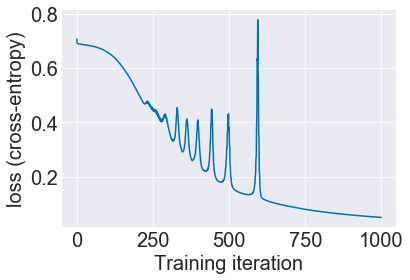

In [87]:
num_inputs = cis_train_x.shape[0]
num_features = cis_train_x.shape[1]
num_hidden_units = 50
num_classes = 2

net_cis = MLP(num_features, num_hidden_units, num_classes)
net_cis.initialize_wts(M=num_features, H=num_hidden_units, C=num_classes, std=0.01)
cis_loss_hist, cis_acc_train, cis_acc_valid = net_cis.fit(cis_train_x, cis_train_y, cis_val_x, cis_val_y, reg=0, print_every=500, lr=0.5, mini_batch_sz=80, n_epochs=1000)
plot_cross_entropy_loss(cis_loss_hist)

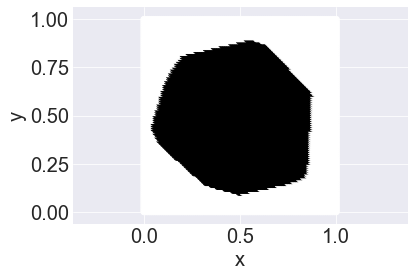

In [92]:
cis_test_ypred = net_cis.predict(cis_test_all[:,:-1])
plt.scatter(cis_test_all[:,0], cis_test_all[:,1], c=cis_test_ypred)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

**Question 5**: How do you interpret the circle-in-square scatterplot? Is the MLP doing a good job? 

**Question 6**: Play with
- number of hidden units
- number of epochs
- batch size

How does each parameter affect the results?

**Question 7**: Do you think the single-layer net (with softmax) can handle the CIS dataset? Why or why not? (You're invited to try it, maybe as an extension :)

**Answer 5**:

**Answer 6**:

**Answer 7**:

### 3d. Test on STL-10 dataset, plot performance

Train an MLP on the STL-10 training set with the following non-default hyperparameters:
- 50 hidden units
- Learning rate of 0.1
- Regularization strength of 0.001
- Mini-batch size of 500
- 100 epochs
    
Make two plots:
- Plot the training loss (like usual).
- Plot the training and validation set accuracies (2 curves in one plot — include a legend, title, axis labels, etc.).

No.epoch: 50
final lose: 2.15997946149685
training acc: 0.488
val acc: 0.382
-----------
No.epoch: 100
final lose: 1.8324867018313764
training acc: 0.6254285714285714
val acc: 0.38
-----------


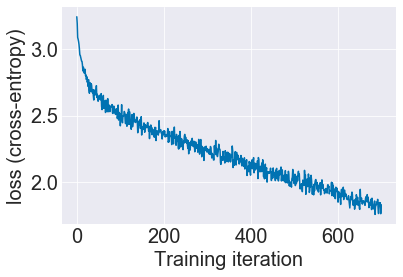

In [94]:
num_inputs = x_train.shape[0]
num_features = x_train.shape[1]
num_hidden_units = 50
num_classes = 10

net_stl = MLP(num_features, num_hidden_units, num_classes)
net_stl.initialize_wts(M=num_features, H=num_hidden_units, C=num_classes, std=0.01)
stl_loss_hist, stl_acc_train, stl_acc_valid = net_stl.fit(x_train, y_train, x_val, y_val, reg=0.001, print_every=50, lr=0.1, mini_batch_sz=500, n_epochs=100)
plot_cross_entropy_loss(stl_loss_hist)

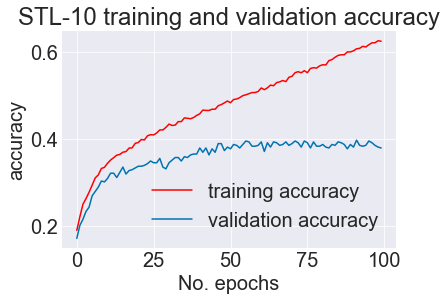

In [99]:
train = plt.plot(stl_acc_train, label="training accuracy", c="r")
val = plt.plot(stl_acc_valid, label="validation accuracy")
plt.legend()
plt.xlabel("No. epochs")
plt.ylabel("accuracy")
plt.title("STL-10 training and validation accuracy")
plt.show()

**Question 7**: What do the above loss and training and validation accuracy curves suggest about the quality of the hyperparameters used during training?

### 3e. Optimize on STL-10 dataset with random search

To optimize your MLP hyperparameters on STL-10, try a **random search** rather than a grid search. This means that instead of defining preset *values* that each hyperparameter takes on, define *ranges* (min and max values).

Run your search for some $T$ iterations. On each iteration, randomly assign values to each hyperparameter within their valid ranges.

Just like grid search, print out the accuracy and parameter values every time a bout of training yields the best accuracy on the STL-10 validation set. That way, if you need to stop the search prematurely, you know the current best parameter combination.

Consider the following hyperparameters:
- learning rate
- regularization strength
- number of hidden units
- mini-batch size

**Important note:** Like usual, I am not grading based on your performance numbers. I want to see that you successfully implemented the random search to find progressively better hyperparameters on STL-10.

**Tip:** Just like with grid search, if you find a cluster of parameters that seems promising, you can revise your search to hone in on that smaller range.

In [113]:
lr_lower = 0.05
lr_upper = 0.5
reg_lower = 0
reg_upper = 0.5
size_lower = 100
size_upper = 1000
num_hu_lower = 10
num_hu_upper = 100

num_inputs = x_train.shape[0]
num_features = x_train.shape[1]
num_classes = 10

max_acc_val = 0 # set to a low value to overwrite
acc_list = []

T = 500
for i in range (T):
    lr = np.random.uniform(lr_lower, lr_upper)
    reg = np.random.uniform(reg_lower, reg_upper)
    size = np.random.random_integers(size_lower, size_upper)
    num_hu = np.random.random_integers(num_hu_lower, num_hu_upper)
    prev_max_acc = max_acc_val

    #start!
    mlp = MLP(num_features, num_hu, num_classes)
    mlp.initialize_wts(M=num_features, H=num_hu, C=num_classes, std=0.01)
    loss_hist, acc_train, acc_valid = mlp.fit(x_train, y_train, x_val, y_val, reg=reg, verbose=0, lr=lr, mini_batch_sz=size, n_epochs=100)

    # print out the final validation accuracy if it's larger than the maximum val_acc we've seen
    if acc_valid[-1] > max_acc_val:
        print(f"Loop #{i}\nlr: {round(lr,5)}\nreg: {round(reg,5)}\nmini_batch sz: {size}\n# hidden units: {num_hu}\nfinal val acc: {acc_valid[-1]}\n-------------------")
        max_acc_val = acc_valid[-1]

    
print(f'finished {T} iterations!')

Loop #0
lr: 0.47501
reg: 0.22617
mini_batch sz: 527
# hidden units: 13
final val acc: 0.268
-------------------
Loop #1
lr: 0.41895
reg: 0.04149
mini_batch sz: 950
# hidden units: 66
final val acc: 0.41600000000000004
-------------------
Loop #2
lr: 0.08096
reg: 0.4544
mini_batch sz: 616
# hidden units: 90
final val acc: 0.236
-------------------
Loop #3
lr: 0.26594
reg: 0.4202
mini_batch sz: 107
# hidden units: 12
final val acc: 0.22399999999999998
-------------------
Loop #4
lr: 0.22422
reg: 0.26362
mini_batch sz: 193
# hidden units: 43
final val acc: 0.26
-------------------
Loop #5
lr: 0.37797
reg: 0.47086
mini_batch sz: 884
# hidden units: 77
final val acc: 0.24
-------------------
Loop #6
lr: 0.14431
reg: 0.42456
mini_batch sz: 853
# hidden units: 51
final val acc: 0.246
-------------------


KeyboardInterrupt: 

### 3f. Plot STL-10 results with best hyperparameters

Train an MLP with the best hyperparameters that you found from your parameter search and create two plots:
- Training STL-10 loss curve
- Training and validation set STL-10 accuracy curves

**Question 8**: Use your best trained network to compute the accuracy on the test set after 200 epochs. What accuracy do you get?

**Question 9:** Why would you use random search over grid search when optimizing parameters on a dataset?

**Answer 8**:

**Answer 9:** 

### 3g. Visualize learned weights

Run the `plot_weights` function to generate a grid visualization of them.

You should see structure in the weights if your network is performing well. If you have a large number of hidden units, some may not be "used" so a subset of the weights may resemble "noise".

In [ ]:
best_y_wts = bestNet.get_y_wts()
best_y_wts = best_y_wts.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)

In [ ]:
def plot_weights(wts, maxRows=25, verbose=0):
    # limit height of figure by number of neurons
    grid_sz = int(maxRows)
    grid_sz = np.minimum(grid_sz, int(np.sqrt(len(wts))))

    if verbose > 0:
        print(f'Showing {grid_sz} rows')
    
    plt.figure(figsize=(20,20))
    for x in range(grid_sz):
        for y in range(grid_sz):
            lin_ind = np.ravel_multi_index((x, y), dims=(grid_sz, grid_sz))
            plt.subplot(grid_sz, grid_sz, lin_ind+1)
            currImg = wts[lin_ind]
            low, high = np.min(currImg), np.max(currImg)
            currImg = 255*(currImg - low) / (high - low)
            currImg = currImg.astype('uint8')
            plt.imshow(currImg)
            plt.gca().axis('off')
    plt.show()

In [ ]:
plot_weights(best_y_wts, verbose=1)

## Extensions

**Reminder**: Please do not integrate extensions into your base project so that it changes the expected behavior of core functions. It is better to duplicate the base project and add features from there.

1) Analyze the differences between training when sampling with replacement (i.e. not every input sample is usually processed on an epoch) and sampling without replacement (e.g. time, accuracy, loss, etc).

2) Investigate how the single layer softmax network does with the CIS dataset. Explain and provide plots showing your results.

3) If you have time to spare (or want to throw more computing power at the STL-10 dataset), process through the SLP and MLP and tune hyperparameters with the dataset at its original resolution (96x96 images). Show images of your learned weights. Can you find a training sweet spot where the learned weight visualizations look particularly cool?

4) Implement a multi-class sigmoid classifer. I suggest creating another subclass of `SoftmaxLayer` and/or `MLP`. Compare and contrast results achieved by the softmax network.

5) Explore alternative MLP architectures and compare/constrast results and performance with the ones used in the base project. For example, replace hidden layer activation function with sigmoid, add one or more additional hidden layers, etc. 

6) Explore the effects of batch gradient descent, stochastic gradient descent, and mini-batch gradient descent. Make plots and interpret your results.

7) Obtain, preprocess, train, and evaluate the performance of `SoftmaxLayer` and/or `MLP` on another dataset with comparable types of image features. MNIST is a good one.

8) Make a fancy coarse-to-fine grid search that automatically "zooms in" on the best hyperparameter combination ranges several times.